In [25]:
%run ../setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle
from utils.cacher import preprocess_flu
import utils.utils_funcs as uf
from run_functions import raw_data_plotter
from subsets_analysis import Subsets

In [3]:
# dictionary of mice and run numbers to analyse
run_dict = {
            'J064' : [10] 
           }

In [4]:
# local path to behaviour pickle files
# this takes a while to load so maybe should do some further caching in the future
pkl_path = os.path.expanduser('~/Documents/code/Vape/run_pkls/')

runs = []
for mouse in run_dict:
    for run_number in run_dict[mouse]:
        run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
        with open(run_path, 'rb') as f:
            r = pickle.load(f)
            runs.append(r)

run = runs[0]

(250000, 300000)

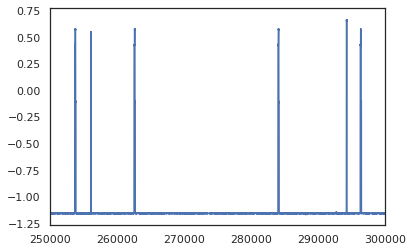

In [5]:
plt.plot(run.x_galvo_uncaging[::100])
plt.xlim((250000, 300000))

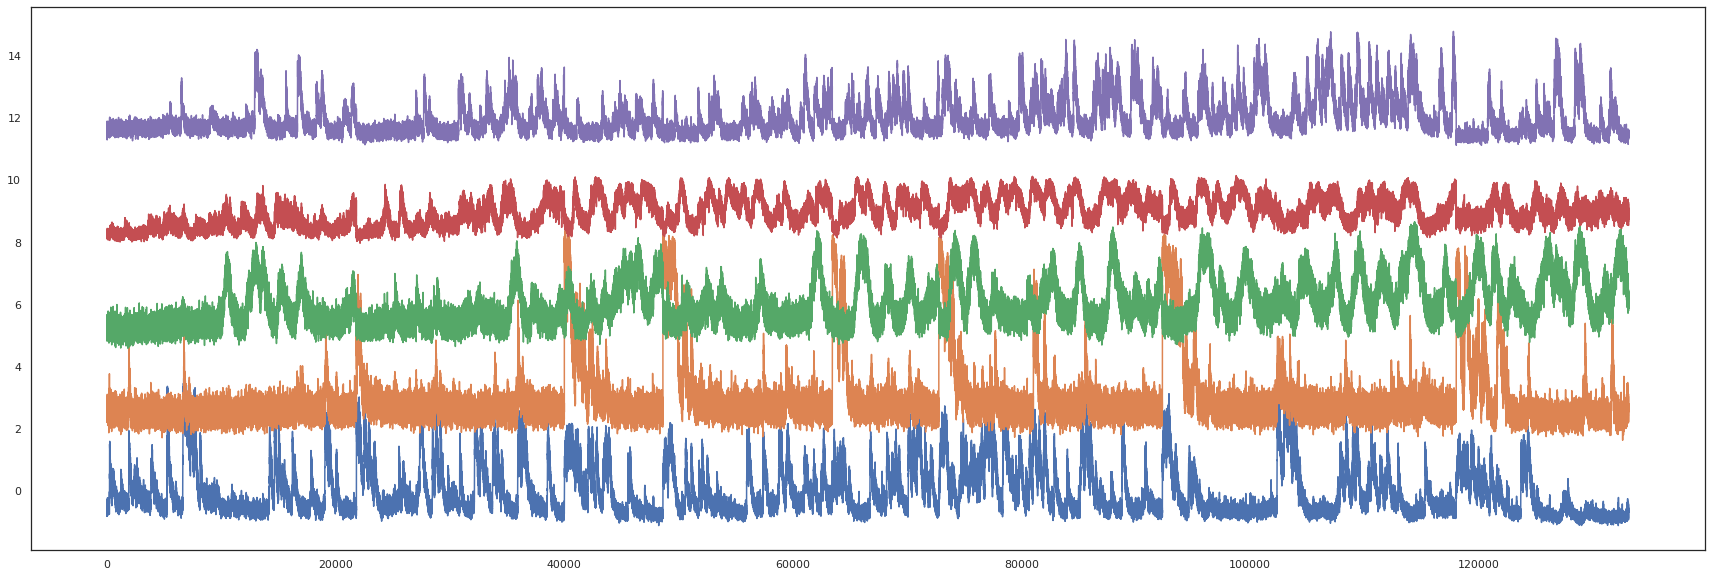

In [9]:
n_cells = 5
plt.figure(figsize=(30,10,))
for i in range(n_cells):
    plt.plot(run.flu[i,:]+i*3)

In [10]:
def get_trial_frames(clock, start, pre_frames, post_frames, fs=30, ye=False):

    frame_idx = uf.closest_frame_before(clock, start)
    trial_frames = np.arange(frame_idx-pre_frames, frame_idx+post_frames)
    
    if ye:
        print(frame_idx)
        print(trial_frames)
    
    # is the trial outside of the frame clock
    is_beyond_clock = np.max(trial_frames) >= len(clock) or np.min(trial_frames) < 0
    
    if is_beyond_clock:
        return None, None
    
    frame_to_start = (start - clock[frame_idx]) / run.paq_rate  # time (s) from frame to trial_start
    frame_time_diff = np.diff(clock[trial_frames]) / run.paq_rate  # ifi (s)
    
    if ye:
        print(frame_to_start)
        print(frame_time_diff)
    
    # did the function find the correct frame
    is_not_correct_frame = clock[frame_idx+1]  < start or clock[frame_idx] > start
    # the nearest frame to trial start was not during trial
    trial_not_running = frame_to_start > 1/fs
    # 
    frames_not_consecutive = np.max(frame_time_diff) > 1/(fs-1)
    
    if trial_not_running or frames_not_consecutive:
        return None, None

    return trial_frames, frame_to_start

In [11]:
def build_flu_array(run, pre_frames=30, post_frames=80, fs=30):
    
    flu = run.flu
    clock = run.paqio_frames
    # the times of trial start in paq samples
    trial_start = uf.threshold_detect(run.x_galvo_uncaging, -0.5)
    assert len(trial_start) == len(run.trial_start)
    fts = []
    for i, start in enumerate(trial_start):
        trial_frames, frame_to_start = get_trial_frames(clock, start, pre_frames, post_frames)       
        fts.append(frame_to_start)
        if trial_frames is None:
            flu_trial = np.full([flu.shape[0], pre_frames+post_frames], np.nan)
        else:
            flu_trial = flu[:, trial_frames]
            
        if i == 0:
            flu_array = flu_trial
        else:
            
            flu_array = np.dstack((flu_array, flu_trial))


    return flu_array, fts

In [12]:
pre_frames = 3
post_frames = 5
flu_array, fts = build_flu_array(run, pre_frames=pre_frames, post_frames=post_frames)

In [13]:
# trial_outcome = np.where(run.outcome=='miss')[0]
trial_outcome = np.arange(flu_array.shape[2])
trial_meaned = np.nanmean(flu_array[:,:,trial_outcome], (0,2))
cell_meaned = np.nanmean(flu_array[:,:,trial_outcome], 0)
cell_meaned.shape

(8, 173)

Text(0, 0.5, 'DFOF')

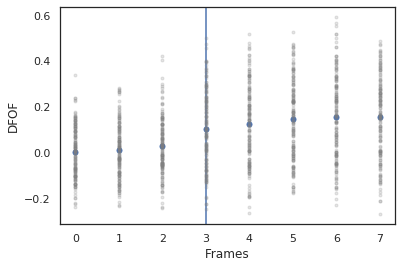

In [14]:
plt.plot(trial_meaned, '.', markersize=10)
plt.axvline(pre_frames)
for trial in range(cell_meaned.shape[1]):
    plt.plot(cell_meaned[:, trial], '.', color='grey', alpha=0.2)
plt.xlabel('Frames')
plt.ylabel('DFOF')

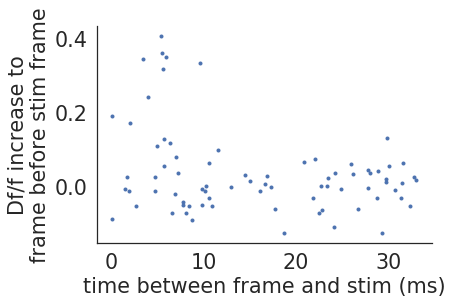

In [28]:
fts_ms = [f*1000 if f is not None else f for f in fts]
plt.ylabel('Df/f increase to\nframe before stim frame')
plt.xlabel('time between frame and stim (ms)')

plt.plot(np.array(fts_ms)[hittys], subbed[hittys], '.')